In [1]:
# Classic libraries
import pandas as pd
import numpy as np

# Data science libraries
import sklearn as sk
from sklearn.cluster import KMeans   # KMeans function
from sklearn.datasets import make_circles, make_blobs  # Datasets
from sklearn.model_selection import train_test_split   # Cross validation library
from sklearn import mixture

# Data visualization libaries
import matplotlib.pyplot as plt
import seaborn as sns   # A must! For nice an easy figures - look for sns command in the notebook
from matplotlib.pyplot import cm   # This is the color chart that I personnaly prefer

%matplotlib inline

# Homemade libraries
from utilities import color, super_scat_it, distance, initiate, estimate_centroid

# Week \#7 - Unsupervised Learning - Exercices

This tutorial will focus on two tasks which used unsupervised learning, namely clustering (Sections 7.2 and 7.3) and dimensionality reduction (Section 7). The goal of this tutorial is to develop basic intuition of classic algorithms used for unsupervised learning.

## 7.1 Data generation

Let's first look at [gaussian mixtures](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model), a relatively simple model, which we will generate with the [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs) function. 

**Remark**: In order to properly run Section 7.2.1, do not change the attributes of the `make_blobs` function in the code snippet below.

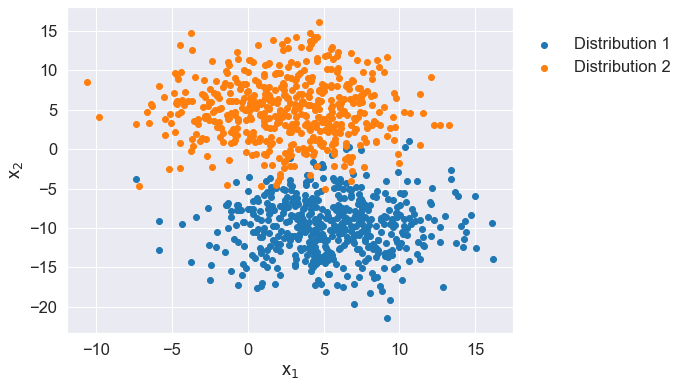

In [2]:
nb_obs = 1000   # Number of observation
k = 2   # Number of clusters
std = 4   # Standard deviation associated to the isotopic Gaussian Mixture - 
dim = 2   # Covariates dimension - if dim > 2, don't expect data vizualisation from matplotlib!
seed = 10   # Random seed to replicate the experience

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, n_features=dim, random_state=seed)   # Data generation

super_scat_it(X, y, k)   # Data visualization - see utilities.py script

## 7.2 Clustering: K-means Algorithm


### 7.2.1 Implementation with numpy

The objective of this section is to implement and understand the procedures associated with the k-means algorithm. First, we will therefore implement the k-means algorithm with numpy.

**Question 7.1**

According to the pseudo code presented on [Slide 18 of the course](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_unsupervised.pdf), complete the `calcul` function of the `k_means` class below.

**Answer 7.1**

In [3]:
class k_means:

    def __init__(self, data, k, seed=None):
        """
        Args:
            data: unlabeled data
            k: number of cluster
        Class Attributes:
            self.data: unlabeled data
            self.centroid: cluster centers
            self.label: label 
            self.iteration: number of iteration before k-means converges
        """
        
        self.data = data
        self.centroid = initiate(data, k)
        self.label = np.argmin(distance(self.data, self.centroid ), axis=1)
            
    def calcul(self):
        
        self.centroid = estimate_centroid(self.data, self.label)
        label_new = np.argmin(distance(self.data, self.centroid), axis=1)
        
        while label_new.tolist() != self.label.tolist():
            self.label = label_new
            self.centroid = estimate_centroid(self.data, self.label)
            label_new = np.argmin(distance(self.data, self.centroid), axis=1)
                        
        self.label = label_new
        self.objective = np.mean(np.min(distance(self.data, self.centroid), axis=1)) 

We can now call the above `k_means` class, estimate the centroids and visualize the associated clusters!

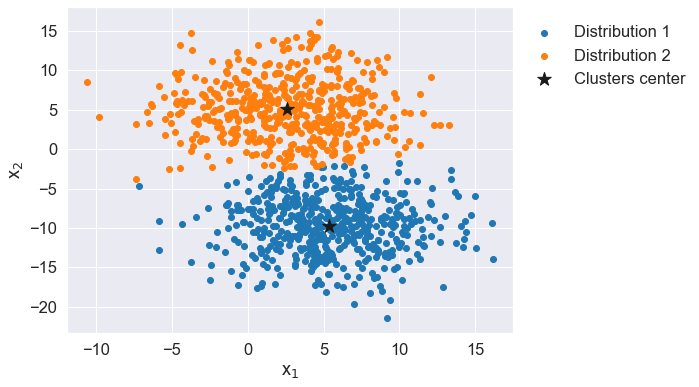

In [4]:
km = k_means(X, k)
km.calcul()

super_scat_it(X, km.label, dim, km.centroid)

### 7.2.2 Exploration of the K-means Algorithm with Scikit Learn

Once the algorithm has been coded, we are going to make our life easier and simply use the [Scikit Learn library](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (-_-).  First, let's check that everything is running fine.

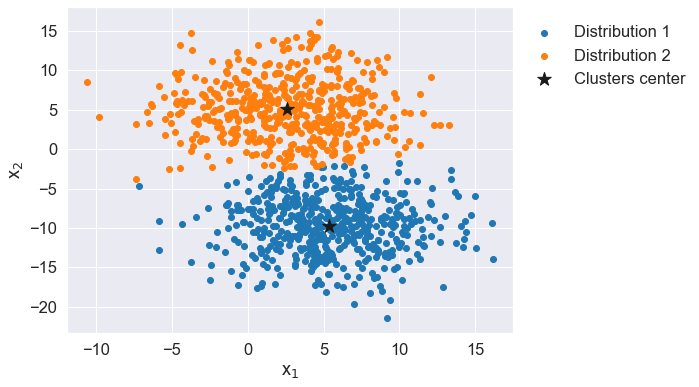

In [5]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
super_scat_it(X, kmeans.labels_, dim, kmeans.cluster_centers_)

### 7.2.3 Choosing the optimal number of clusters

Until now, we knew the actual number of subpopulations (parameterized by the variable $ k $) associated with the simulated data. On the other hand, with non simulated datasets, the data is only very rarely labeled. It is therefore important to develop methodologies in order to clearly define the number of clusters required.

**Questions 7.2**

1. Find a simple way to determine the optimal number of clusters.
2. Implement it.
3. How many clusters would you choose?

**Answers 7.2**

1. We can code a procedure based on cross-validation. Hence, we could define a threshold from which a decrease in the value of the objective function is no longer considered interesting. 
2. The cross-validation procdure is coded below.
3. 2 clusters seems a fair choice.

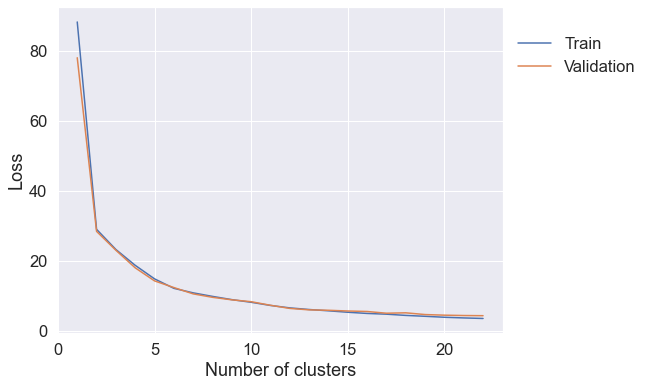

In [6]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

max_cluster = 22

for k in np.arange(max_cluster)+1:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    loss_train.append(np.mean(np.min(distance(X_train, kmeans.cluster_centers_), axis=1)))
    loss_valid.append(np.mean(np.min(distance(X_valid, kmeans.cluster_centers_), axis=1)))

plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Number of clusters')
plt.ylabel('Loss')

leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

**Questions 7.3**

   1. Are you disapointed by the behavior of the curve associated to the validation set?
   2. Considering the results obtained here, could you imagine a better way to obtain the optimal number of clusters?
   
**Answers 7.3**

   1. No, I am not. That's what exactly what I expected (see explanation below).
   2. Yes indeed! Let's think twice. The loss function considered aims in fact to minimize the variance within the different clusters. Therefore, the question comes down to asking whether the addition of a new cluster sufficiently reduces the intra-cluster variance. However, under the assumption of normality of the observations, which is the case here, we can suppose that each of the variances under study follows a chi-square law (!). We could therefore create a test in order to know if the sums of the chi-squares, in the case where we have $k$ or $k + 1$ clusters, are significantly different. Which is great, because many of you are familiar with this test: F-test! 

The previous exercise was based on a relatively simple dataset. Indeed, there was large number of observations ($n = 1000$) for a relatively small variable space ($\bf{X} \in \mathbb{R}^2$) and small number of clusters ($k = 2$). In order to validate the relevance of the cross-validation procedure to fix the number of clusters, let's now simulate a slightly more complex dataset.

In [7]:
nb_obs = 100   # Number of observation
k = 10   # Number of clusters
std = 4   # Standard deviation associated to the isotopic Gaussian Mixture - 
dim = 50   # Covariates dimension - if dim > 2, don't expect data vizualisation from matplotlib!
seed = 10   # Random seed to replicate the experience

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, n_features=dim, random_state=seed)   # Data generation

Let's now look how the loss associated to the validation set behave on a more complex dataset.

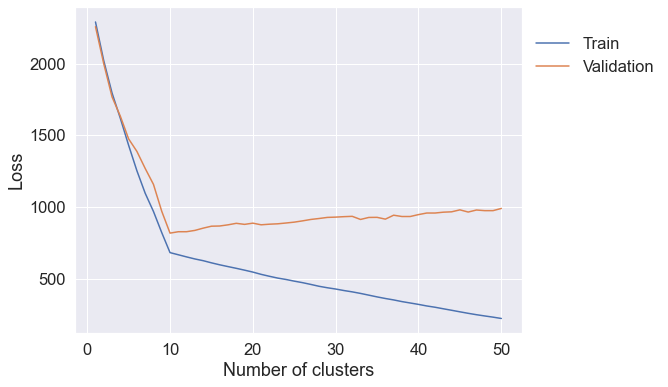

In [8]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

max_cluster = 50

for k in np.arange(max_cluster)+1:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    loss_train.append(np.mean(np.min(distance(X_train, kmeans.cluster_centers_), axis=1)))
    loss_valid.append(np.mean(np.min(distance(X_valid, kmeans.cluster_centers_), axis=1)))

plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Number of clusters')
plt.ylabel('Loss')

# Ghosting the legend
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

**Questions 7.4**

   1. Are you suprised by the behavior of the curve associated to the training set?
   2. Are you disapointed by the behavior of the curve associated to the validation set?
    
**Answers 7.4**

   1. No, we are not. That's what exactly what we expected. Ultimately, the curve associated to the training dataset will converge (with respect to the number of clusters) to 0 (make sure understand why).
   2. No! You are not! That's what exactly what you expected. According to the above figure, the validation curve find a global minimum for 10 clusters! :D


## 7.3 Clustering - The Gaussian Mixture Model

We will now consider the [Expectation Maximisation algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) (EM) in order to estimate mixtures of Gaussians. As presented on [Slides 26 to 41 of the course](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_unsupervised.pdf), the idea is simply to associate each observation with a probability of belonging to one or the other of the distributions.

Coding the EM algorithm in numpy can be a tedious exercise, so we'll just use the [following library](https://scikit-learn.org/0.16/modules/generated/sklearn.mixture.GMM.html).

No handles with labels found to put in legend.


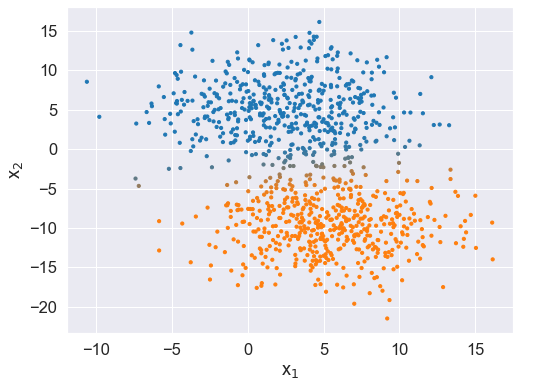

In [9]:
cluster_std=4
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=cluster_std, n_features=2, random_state=10)   # Data generation

nb_components = 2
GMM = mixture.GaussianMixture(n_components=nb_components, covariance_type='full')
GMM.fit(X)

super_scat_it(X, GMM.predict_proba(X), dim=nb_components, clusters_center=0, task='EM')

**Questions 7.5**

1. After a quick glance at the figure above, what do you notice that is different from the k-means algorithm?
2. What would have happened if we had set the parameter associated with the variance of the sub-populations (`cluster_std`) to 2?

**Answers 7.5**

1. Some observations seem to have a mixed assignor. This is expected, since the responsibilities assigned in a GMM can be considered as probabilities.
2. Try it!

### 7.3.1 Choosing the optimal number of clusters for a GMM

**Questions 7.6**

1. How do we define the right number of clusters?
2. Are the curves behave as those previously studied (with the k-means algorithm)? Does it make sense?
2. Could you imagine another way to find the optimal number of mixtures?

**Answers 7.6**

1. As previously seen, we can use cross-validation (see code below).
2. No. GMMs are a probalistic approach based on the maximisation of the likelihood. In the figure below for instance, the algorithm aims to maximize the negative log-likelhood.
3. According to the previous answer, we could use model selection criteria as the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) wich penalized nonparsimonious models.

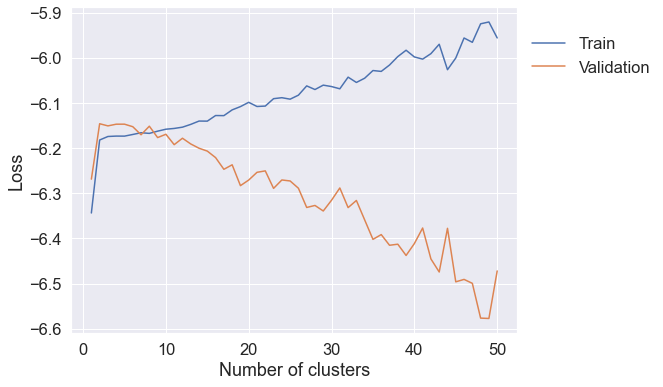

In [10]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

for k in np.arange(max_cluster)+1:
    GMM = mixture.GaussianMixture(n_components=k, covariance_type='full')
    GMM.fit(X_train)
    
    loss_train.append(GMM.score(X_train))
    loss_valid.append(GMM.score(X_valid))
            
plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Number of clusters')
plt.ylabel('Loss')

# Ghosting the legend
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

## 7.4 Dimensionality Reduction: Autoencoder

### 7.4.1 Model

Autoencoders (AE) are a class of neural networks that allow unsupervised learning of the latent characteristics of the data being studied. To do this, the AE will attempt to predict, or copy, the input observations using (multiple) hidden layer. In its simplest form, the architecture of an AE can be summarized in the diagram below.

![title](./Images/AE.png)

Looking more closely, the AE consists of an encoder, the function $h(\cdot)$ defined by:

$$
\begin{align}
    h(\mathbf{x}) = \frac{1}{1+ \exp(-\mathbf{W} \mathbf{x})}.
\end{align}
$$

This function takes as input the observations and will consist of recoding it as a hidden layer so as to reduce their size (fewer neurons). Afterwards, an encoder defined by:

$$
\begin{align}
    f(h(\mathbf{x})) = \mathbf{W}^\top h(\mathbf{x})
\end{align}
$$

will attempt <i>to reconstruct </i> the input observations from the hidden layer. In this sense, the AE tries to estimate the observations used as input.

### 7.4.2 AEs with Pytorch

In order to build an autoencoder, we will use the
<a href="https://pytorch.org/">Pytorch</a> library. It provides two extremely interesting features:
<ul>
<li> Manipulation of tensors (kind of multidimensional matrices) to perform calculations with GPU. </li>
<li> Automatic differentiation (!!!) with the <a href="http://pytorch.org/docs/master/autograd.html">autograd class </a> to easily calculate the gradient descent. </li>

In [11]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

### 7.4.3 Data simulation

Let's first simulate more complex gaussian mixtures (look at the number of clusters and the dimension of the data) in order to understand the behavior of the AEs.

In [22]:
nb_obs = 10**3   # Number of observations
k = 4   # Number of clusters
std = 1   # Standard deviation associated to the isotopic Gaussian Mixture - 
dim = 20   # Covariates dimension - if dim > 2, don't expect data vizualisation from matplotlib!

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, n_features=dim, random_state=10)   # Data generation
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)

Since we will work with Pytorch, let's turn the training and validation datasets into tensors.

In [23]:
X_train, X_valid = torch.from_numpy(X_train), torch.from_numpy(X_valid) 

train_loader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(X_valid, batch_size=64, shuffle=True, num_workers=2)

**!! Remark !!** 

Although the documentation available for Pytorch is detailed (compared to other deep learning libraries), it is easy to get lost. Nevertheless, for this workshop, it is not necessary to enter all the details associated with the different commands. In fact, the key is to understand the ins and outs of the key steps presented.

### 7.4.4 Building the model

#### 7.4.4.1 AE initialization

First, let's define the autoencoder class using the <a href="http://pytorch.org/docs/master/nn.html#module"> torch.nn</a> module. In PyTorch, any neural network must inherit this class. The autoencoder uses other common classes in Pytorch, such as <a href = "http://pytorch.org/docs/master/nn.html#torch.nn. Linear "> torch.nn.Linear (in_features, out_features)</a>. The latter implements a fully connected linear layer (as its name suggests).

During the propagation phase, the `forward` function associated with the propagation of the message defines the operations to be performed in order to calculate the elements of the output. This function is essential and must match the initialization of the model in the previous step to allow proper backpropagation. 
   
Note the use of the <a href="http://pytorch.org/docs/master/nn.html#torch-nn-functional">torch.nn.functional</a> method which define a set of functions which can be applied to the layers of a neural network.

In [24]:
class AE(nn.Module):
    def __init__(self, inputs, outputs, features, criterion=None, optimizer=None):
        """
        Args: 
           self: class name
           nb_inputs: number of neurons on the input layer
           nb_outputs: number of neurons on the output layer
           nb_features: number of neurons on the hidden layer
           criterion: loss function used for learning  
        """
        
        super(AE, self).__init__()
        self.fc1 = nn.Linear(inputs, features)
        self.fc2 = nn.Linear(features, outputs)
        
        self.criterion = criterion
        self.optimizer = optimizer
    
    def forward(self, x):
        """
        Args:
            x: input layer, here made up of 1682 neurons
        Return:
            predictions: output layer
        """
    
        h1 = torch.sigmoid(self.fc1(x))
        return self.fc2(h1)

We defined:

1. The number of neurons input,
2. The number of neurons output, which should be the same as the one in input,
3. The number of neurons desired in the hidden layer, which should be smaller than the number of neurons in input.

**Question 7.7**

Why should the dimension of the hidden layer be smaller than the dimension of the input layer?

**Answer 7.7**

One aim of an AE is to learn a latent and succinct representation of the data. We can see the hidden layer as an information bottleneck (see Slide 54 of the class). If the dimension of the hidden layer is as large as that of the data, the use of an AE in this specific case is futile. Morever, we could imagine that in such a case, the latent representation learned by the AE is identical in all respects to the data, which would automatically minimize a loss function such as the MSE.

We can now properly initialize the AE.

In [25]:
inputs_dim = dim
hidden_dim = 4

ae = AE(inputs_dim, inputs_dim, hidden_dim)

#### 7.4.4.2 Loss function

Loss function plays an important role in the construction of a supervised and unsupervised models. In fact, it is this same loss function that we try to minimize (or maximize is according to) by iteratively adjusting the weights of the AE. Thus, two different loss functions will most likely result in two different models. As usual, Pytorch offers a large amount of <a href="http://pytorch.org/docs/master/nn.html#id42">loss functions</a> that you can explore at your leisure.

Since the data follow gaussians distribution, the mean square error (MSE) seems an interesting first option. Since we have encoded the loss function as an attribute of the autoencoder class, we define it with the following command.

In [26]:
ae.criterion = nn.MSELoss()

#### 7.4.4.3 Optimizer

PyTorch provides several <a href="http://pytorch.org/docs/master/optim.html#algorithms">optimization methods</a> more or less derived from the gradient descent via the `torch 'class. optim`. Among these techniques:

<ul>
<li> SGD (Stochastic Gradient Descent): implementation of SGD.
<li> Adam (Adaptive Moment Estimation): variation of the gradient descent method where the learning rate is adjusted for each parameter.
</ul>

In [27]:
learning_rate = 1e-1
ae.optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)

#### 7.4.4.4 Learning loop

The learning loop goes as follow. Note that the parameters are not optimized during the validation phase and can be controlled with the training attribute.

In [28]:
def learning(model, data, training=True):
    
    losses = []
    for batch_idx, inputs in enumerate(data):
        
        if training:
            model.optimizer.zero_grad()
        
        targets = inputs.clone()
        outputs = model(inputs.float())
        loss = model.criterion(outputs, targets.float())
        
        if training:
            loss.backward()
            model.optimizer.step()
            loss = model.criterion(model(inputs.float()), targets.float())
        
        losses.append(loss.data.item())   
        
    return np.mean(losses)

#### 7.4.4.5 Training

The autoencoder and the associated functions now implemented, we can start to train the model. Once again, the goal here is not to tune the parameters so as to obtain the best possible model, but simply to understand the role that they can play according to the model's predictive ability.

In [29]:
nb_epoch = 51   # Number of iterations
train_losses, valid_losses = [], []

for epoch in range(0, nb_epoch):
    
    train_losses.append(learning(model=ae, data=train_loader))
    valid_losses.append(learning(model=ae, data=valid_loader, training=False))
     
    if epoch % 5 == 0: 
        print("epoch: ", "{:3.0f}".format(epoch), "   |   train: ", "{:1.3f}".format(train_losses[-1]), \
                        '   |   valid: ', "{:1.3f}".format(valid_losses[-1]))

epoch:    0    |   train:  25.474    |   valid:  20.549
epoch:    5    |   train:  7.153    |   valid:  6.254
epoch:   10    |   train:  3.739    |   valid:  3.251
epoch:   15    |   train:  2.133    |   valid:  1.982
epoch:   20    |   train:  1.431    |   valid:  1.360
epoch:   25    |   train:  1.147    |   valid:  1.154
epoch:   30    |   train:  1.044    |   valid:  1.016
epoch:   35    |   train:  1.007    |   valid:  1.029
epoch:   40    |   train:  0.998    |   valid:  1.015
epoch:   45    |   train:  0.997    |   valid:  1.001
epoch:   50    |   train:  0.997    |   valid:  1.016


Let's take a quick look at how the AE behaves through epochs.

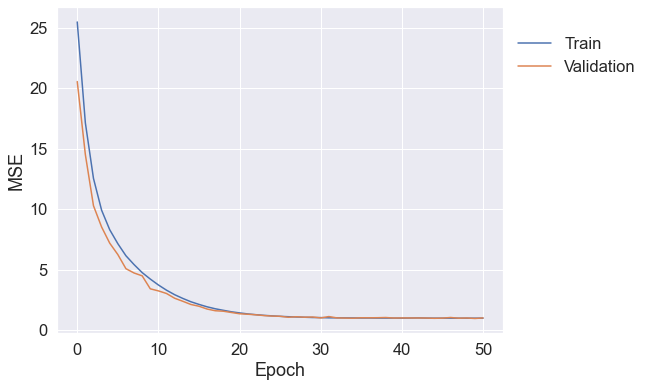

In [30]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale = 1.5)

plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('MSE')

# Ghosting the legend
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

### 7.4.5 A representation study

Now that the AE is trained, we can look at the latent representation given by the hidden layer. Since we want to visualize the hidden states, we can simply compare the two by two representations from a small amount of data.

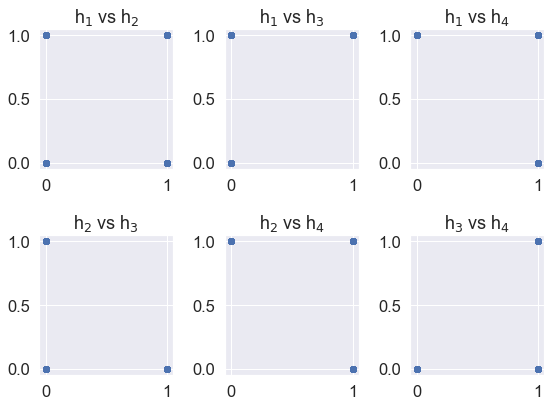

In [31]:
# A small amout of data
it = iter(enumerate(train_loader))   
i, x = next(it)

# Let's get the hidden representation
outputs = torch.sigmoid(ae.fc1(x.float()))   
outputs = outputs.detach()

# Visualization
fig, axs = plt.subplots(2, 3)
axs[0, 0].scatter(outputs[:, 1], outputs[:, 0])
axs[0, 0].set_title("h$_1$ vs h$_2$")
axs[0, 1].scatter(outputs[:, 2], outputs[:, 0])
axs[0, 1].set_title("h$_1$ vs h$_3$")
axs[0, 2].scatter(outputs[:, 3], outputs[:, 0])
axs[0, 2].set_title("h$_1$ vs h$_4$")
axs[1, 0].scatter(outputs[:, 2], outputs[:, 1])
axs[1, 0].set_title("h$_2$ vs h$_3$")
axs[1, 1].scatter(outputs[:, 3], outputs[:, 1])
axs[1, 1].set_title("h$_2$ vs h$_4$")
axs[1, 2].scatter(outputs[:, 3], outputs[:, 2])
axs[1, 2].set_title("h$_3$ vs h$_4$")
fig.tight_layout()

**Questions 7.8**

1. Are the sublots behave as you expected? How?
2. Run the same experiment again without changing the hyperparameters. What do you notice? Does the latent representation seem to have changed?
3. Would the subplots have been different if we had simulated the data from 2 clusters instead of 4? Try it! 
4. How could you profit from the information represented in the hidden layers?

**Answers 7.8**

1. At first glance, the latent representations seem to have encoded the distributions associated with the 4 different clusters. In fact, most of the observations cluster at 4 different points, which are associated with each of the mixtures.
2. There is a good chance that it does! We can just see it by looking at the new figures above.
3. Absolutely! We would just have seen a maximum of two points on the subplots.
4. We could use the latent representation of each observation to subsequently associate it with a particular mixture, as we did in the sections about clustering.